In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.status()

  Activating project at `~/Documents/Carnegie-Mellon/Chatterjee Group/Programming/WignerMolecule.jl/analysis`


Status `~/Documents/Carnegie-Mellon/Chatterjee Group/Programming/WignerMolecule.jl/analysis/Project.toml`
  [13f3f980] CairoMakie v0.15.6
  [780c37f4] Carlo v0.2.5
  [a93c6f00] DataFrames v1.8.0
  [f67ccb44] HDF5 v0.17.2
  [033835bb] JLD2 v0.6.2
  [ebeed567] PeriodicArrays v0.1.0 `https://github.com/PatXue/PeriodicArrays.jl#main`
  [90137ffa] StaticArrays v1.9.15


In [2]:
using CairoMakie
using Carlo.ResultTools
using DataFrames
using HDF5
using JLD2
using LinearAlgebra
using PeriodicArrays
using StaticArrays

In [50]:
# Parse DataFrame from ResultTools into more readily useable form
cleandata(filepath::AbstractString) = select(
    DataFrame(ResultTools.dataframe(filepath)),
    [:init_type, :T, :Lx, :Ly, :Mag, :Energy, :ηz, :ηxy, :spin_ks, :eta_ks]
)
# Parse and return DataFrame of sweep and measure times
function parsetimes(filepath::AbstractString)
    data = DataFrame(ResultTools.dataframe("../jobs/afm-fe-center.results.json"))
    return data[:, [:T, :_ll_sweep_time, :_ll_measure_time]]
end

parsetimes (generic function with 1 method)

In [4]:
function generatePlot(data::AbstractDataFrame, x, y;
                      title="", xlabel="", ylabel="", line=false)
    ax = Axis(fig; title, xlabel, ylabel)

    vals = getfield.(data[:, y], :val)
    errs = getfield.(data[:, y], :err)
    scatter!(data[:, x], vals)
    if line
        lines!(data[:, x], vals)
    end
    errorbars!(data[:, x], vals, errs)

    return ax
end

function generatePlot(data::AbstractDataFrame, x, ys::Vector;
                      title="", xlabel="", ylabel="", line=false)
    ax = Axis(fig; title, xlabel, ylabel)

    for (label, y) in zip(ys, eachcol(data[:, ys]))
        vals = getfield.(y, :val)
        errs = getfield.(y, :err)
        scatter!(data[:, x], vals; label="$label")
        if line
            lines!(data[:, x], vals)
        end
        errorbars!(data[:, x], vals, errs)
    end
    axislegend()

    return ax
end

function generatePlot(data::GroupedDataFrame, x, y;
                      title, xlabel, ylabel, line=false)
    ax = Axis(fig; title, xlabel, ylabel)

    for key in keys(data)
        group = data[key]
        vals = getfield.(group[:, y], :val)
        errs = getfield.(group[:, y], :err)
        scatter!(group[:, x], vals, label="$(NamedTuple(key))")
        if line
            lines!(group[:, x], vals)
        end
        errorbars!(group[:, x], vals, errs)
    end

    axislegend()

    return ax
end

generatePlot (generic function with 3 methods)

In [5]:
function generate_spins(jobname, task_no)
    fig = Figure(size=(800, 400))

    task_str = lpad(task_no, 4, "0")
    h5open("../jobs/$jobname.data/task$task_str/run0001.dump.h5") do file
        spins = map(
            t -> [t[:data][1], t[:data][2], t[:data][3]],
            read(file, "simulation/spins")
        )
        spin_xs = map(v -> v[1], spins)
        spin_ys = map(v -> v[2], spins)
        spin_zs = map(v -> v[3], spins)
        Lx, Ly = size(spins)
        fig[1,1] = Axis(fig; title="Spins", backgroundcolor="black")
        strength = vec(spin_zs)
        arrows2d!(1:Lx, 1:Ly, spin_xs, spin_ys, lengthscale=0.5, align=:center, color=strength,
                  colorrange=(-1, 1))

        ηs = map(
            t -> [t[:data][1], t[:data][2], t[:data][3]],
            read(file, "simulation/etas")
        )
        η_xs = getindex.(ηs, 1)
        η_ys = getindex.(ηs, 2)
        η_zs = getindex.(ηs, 3)
        Lx, Ly = size(ηs)
        fig[1,2] = Axis(fig; title="ηs", backgroundcolor="black")
        strength = vec(η_zs)
        arrows2d!(1:Lx, 1:Ly, η_xs, η_ys, lengthscale=0.5, align=:center, color=strength,
                  colorrange=(-1, 1))
    end

    return fig
end

generate_spins (generic function with 1 method)

In [6]:
function generate_mctime_plot(jobname, task_no::Int, observable::Symbol, fig=Figure(size=(800, 400)),
                              fig_pos=(1, 1))
    ax = fig[fig_pos...] = Axis(
        fig,
        title="$observable vs. Bin #",
        xlabel="Bin #",
        ylabel="$observable",
        xminorticksvisible=true
    )

    task_str = lpad(task_no, 4, "0")
    h5open("../jobs/$jobname.data/task$task_str/run0001.meas.h5") do file
        observables = file["observables"]

        samples = read(observables, "$observable/samples")
        n = length(samples)
        init = 1
        lines!(ax, collect(1:n), samples[1:n])
    end

    return fig
end

generate_mctime_plot (generic function with 3 methods)

## AFM-FE Phase Border

In [ ]:
jobname = "afm-fe"
data = cleandata("../jobs/$jobname.results.json")

Row,init_type,T,Lx,Ly,Mag,Energy,ηz,ηxy
,String,Float64,Int64,Int64,Measurem…,Measurem…,Measurem…,Measurem…
1,afm_fe,0.01,20,20,0.000438±5.5e-5,-49.9967±0.0016,-0.00053±0.0001,0.999903±1.1e-6
2,afm_fe,0.025,20,20,0.00078±4.8e-5,-49.9552±0.0042,0.00023±0.00018,0.999786±2.5e-6
3,afm_fe,0.05,20,20,0.0168±0.0029,-30.9±3.6,0.00028±0.00028,0.41±0.11
4,afm_fe,0.075,20,20,0.02602±0.0001,-19.38±0.025,-0.00023±0.00024,0.05994±0.00081
5,afm_fe,0.1,20,20,0.0214±0.0023,-25.3±2.9,-0.0002±0.00029,0.241±0.089
6,afm_fe,0.125,20,20,0.02571±0.00043,-20.02±0.62,-0.00028±0.00019,0.08±0.019
7,afm_fe,0.15,20,20,0.02619±7.6e-5,-19.342±0.024,0.00018±0.00037,0.06022±0.00087
8,afm_fe,0.175,20,20,0.026046±9.5e-5,-19.332±0.011,0.00011±0.00037,0.06004±0.00059
9,afm_fe,0.2,20,20,0.02606±0.00013,-19.326±0.021,-0.00035±0.00028,0.05943±0.00061


In [39]:
parsetimes("../jobs/$jobname.results.json")

Row,_ll_sweep_time,_ll_measure_time
,Measurem…,Measurem…
1,0.00037214±4.7e-7,8.5e-5±2.4e-5
2,0.00037315±6.7e-7,4.178e-5±3.8e-7
3,0.00037496±8.4e-7,4.17e-5±2.9e-7
4,0.0003815±1.5e-6,4.16e-5±2.5e-7
5,0.0003877±3.4e-6,4.223e-5±4.3e-7
6,0.0003905±1.0e-6,4.162e-5±2.9e-7
7,0.00038843±9.1e-7,4.172e-5±2.0e-7
8,0.000387±1.1e-6,4.144e-5±2.1e-7
9,0.0003869±1.2e-6,4.219e-5±4.9e-7


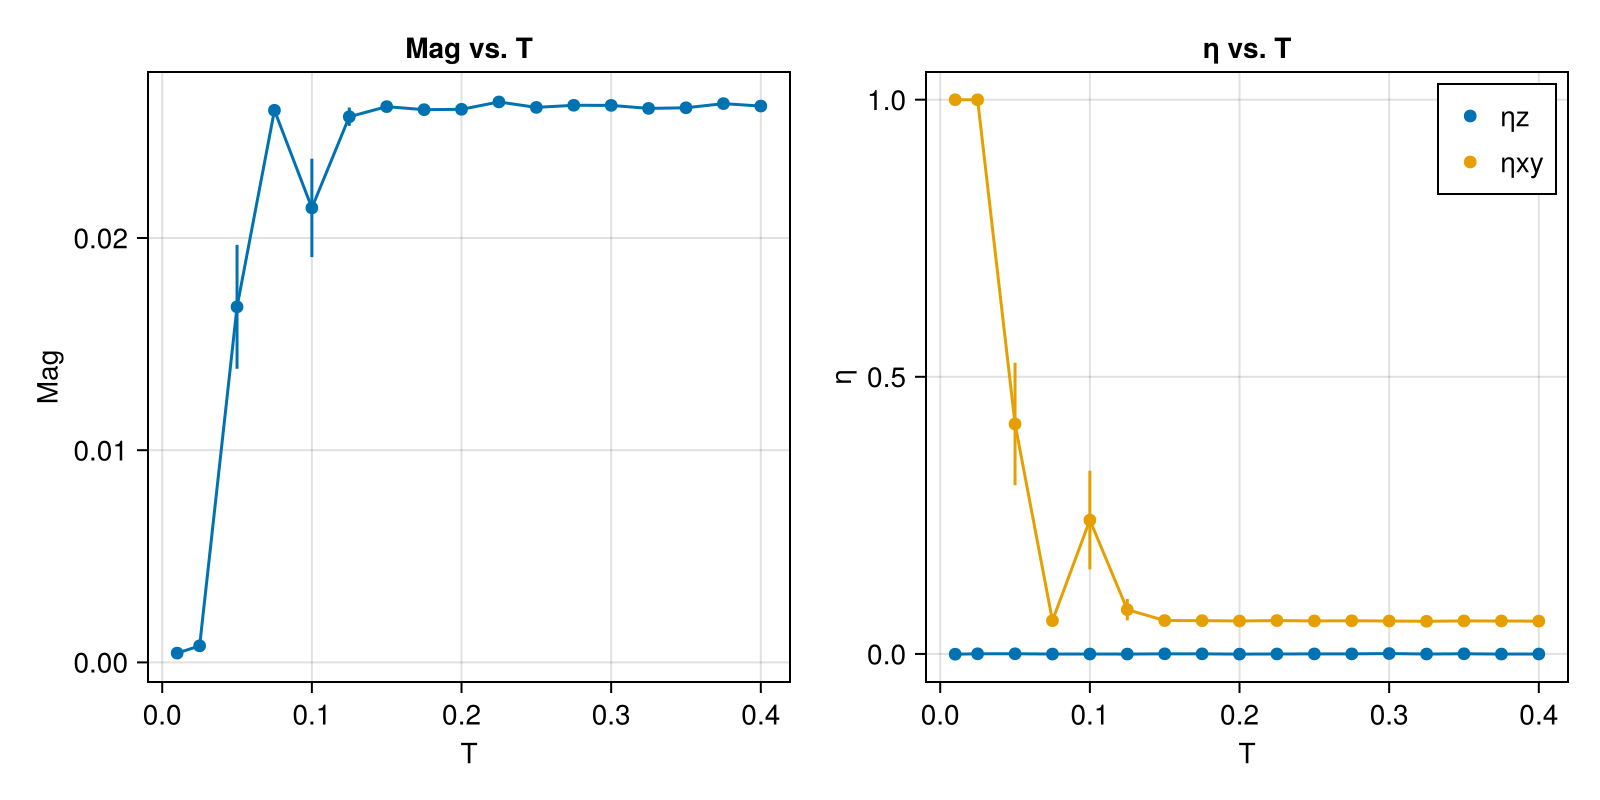

In [8]:
fig = Figure(size=(800, 400))
fig[1,1] = generatePlot(data, :T, :Mag; title="Mag vs. T", xlabel="T", ylabel="Mag", line=true)
fig[1,2] = generatePlot(data, :T, [:ηz, :ηxy]; title="η vs. T", xlabel="T", ylabel="η", line=true)
fig

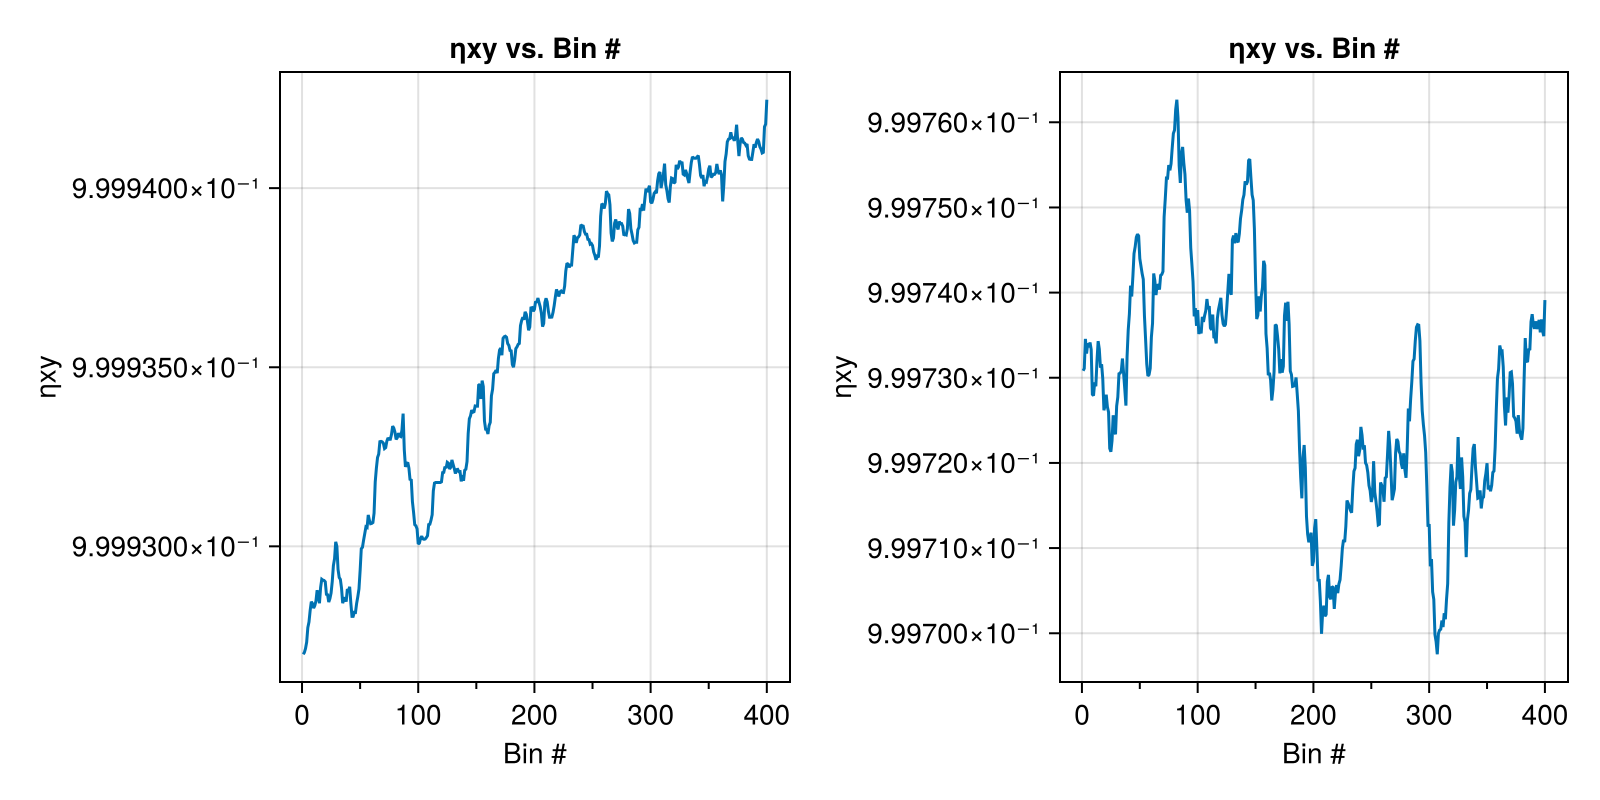

In [15]:
fig = Figure(size=(400, 800))
i = 1
fig = generate_mctime_plot(jobname, i, :ηxy)
generate_mctime_plot(jobname, i+1, :ηxy, fig, (1, 2))

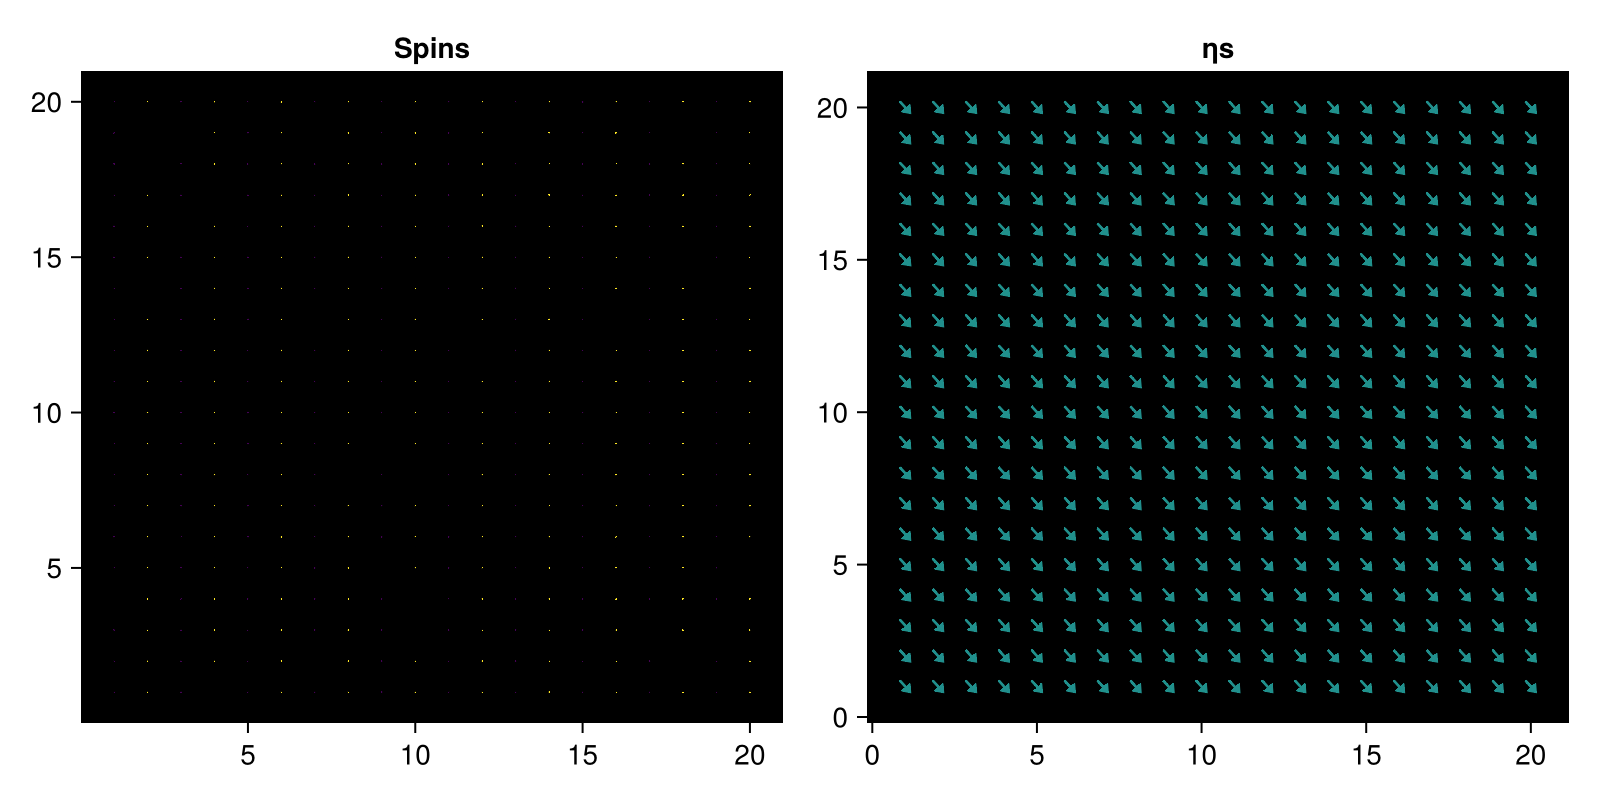

In [16]:
generate_spins(jobname, 1)

## AFM-FE Phase Center

In [49]:
jobname = "afm-fe-center"
data = cleandata("../jobs/" * jobname * ".results.json")

Row,init_type,T,Lx,Ly,Mag,Energy,ηz,ηxy,spin_ks,eta_ks
,String,Float64,Int64,Int64,Measurem…,Measurem…,Measurem…,Measurem…,Array…,Array…
1,afm_fe,0.01,20,20,0.000324±2.5e-5,-92.1152±0.002,0.000458±5.4e-5,0.99994±9.4e-7,Complex{Measurement{Float64}}[0.037±0.016+0.0±0.0im 0.055±0.014-0.0342137±0.0im … 0.02±0.02-0.0139323±0.0im 0.055±0.014+0.0342137±0.0im; 0.017±0.019+0.0484722±0.0im 0.0057±0.016+0.00577632±0.0im … 0.023±0.015-0.00720517±0.0im 0.0042±0.025+0.0281818±0.0im; … ; 0.0033±0.026+0.00659176±0.0im 0.047±0.017-0.0145732±0.0im … 0.071±0.021-0.0619854±0.0im -0.031±0.032+0.00636293±0.0im; 0.017±0.019-0.0484722±0.0im 0.0042±0.025-0.0281818±0.0im … -0.11±0.013+0.00902869±0.0im 0.0057±0.016-0.00577632±0.0im;;; 0.018±0.027+0.0±0.0im -0.093±0.021-0.0235683±0.0im … -0.0091±0.015+0.0111464±0.0im -0.093±0.021+0.0235683±0.0im; 0.038±0.016+0.0408292±0.0im 0.077±0.019-0.032861±0.0im … -0.091±0.016-0.0118873±0.0im -0.048±0.026-0.010138±0.0im; … ; 0.011±0.022+0.0429759±0.0im 0.053±0.024+0.0655539±0.0im … 0.018±0.017-0.0460526±0.0im 0.014±0.022+0.0345441±0.0im; 0.038±0.016-0.0408292±0.0im -0.048±0.026+0.010138±0.0im … 0.0038±0.025-0.0775145±0.0im 0.077±0.019+0.032861±0.0im;;; 0.00045±0.00035+0.0±0.0im 0.00016±0.00043+0.000809112±0.0im … 0.00029±0.00034+0.000899327±0.0im 0.00016±0.00043-0.000809112±0.0im; 0.00064±0.00038+0.000288751±0.0im 0.00068±0.00023+0.000240961±0.0im … -0.00066±0.00034+8.92991e-5±0.0im 0.00067±0.00022+0.000910654±0.0im; … ; -0.0001±0.0003-0.000554478±0.0im 0.00052±0.00025-0.000316363±0.0im … 0.00094±0.00041+0.000346252±0.0im -0.00021±0.00024-0.000922801±0.0im; 0.00064±0.00038-0.000288751±0.0im 0.00067±0.00022-0.000910654±0.0im … 0.00083±0.0003+0.000917693±0.0im 0.00068±0.00023-0.000240961±0.0im],Complex{Measurement{Float64}}[257.153±0.014+0.0±0.0im 0.029±0.018-0.017245±0.0im … -0.055±0.015-0.0220954±0.0im 0.029±0.018+0.017245±0.0im; 0.029±0.015-0.0242776±0.0im 0.044±0.021-0.00653394±0.0im … 0.043±0.016+0.0701937±0.0im -0.0015±0.016+0.00103973±0.0im; … ; 1.5e-5±0.014-0.0532351±0.0im 0.053±0.02-0.0277878±0.0im … -0.047±0.013-0.0137932±0.0im 0.05±0.02-0.00591127±0.0im; 0.029±0.015+0.0242776±0.0im -0.0015±0.016-0.00103973±0.0im … 0.01±0.018-0.0139781±0.0im 0.044±0.021+0.00653394±0.0im;;; -306.355±0.012+0.0±0.0im 0.025±0.015-0.012856±0.0im … -0.045±0.013-0.0199891±0.0im 0.025±0.015+0.012856±0.0im; 0.025±0.013-0.0196077±0.0im 0.038±0.017-0.00459495±0.0im … 0.036±0.014+0.0585485±0.0im -0.00022±0.014+0.00106538±0.0im; … ; -0.0004±0.012-0.0440682±0.0im 0.045±0.017-0.024051±0.0im … -0.036±0.011-0.0105337±0.0im 0.041±0.017-0.00479819±0.0im; 0.025±0.013+0.0196077±0.0im -0.00022±0.014-0.00106538±0.0im … 0.0072±0.015-0.0106713±0.0im 0.038±0.017+0.00459495±0.0im;;; 0.183±0.022+0.0±0.0im -0.176±0.016+0.0569756±0.0im … 0.029±0.027-0.143713±0.0im -0.176±0.016-0.0569756±0.0im; 0.101±0.027+0.0747174±0.0im -0.071±0.024+0.155911±0.0im … -0.045±0.021+0.00473503±0.0im 0.086±0.021-0.102059±0.0im; … ; -0.016±0.02-0.130746±0.0im 0.044±0.029-0.121288±0.0im … -0.087±0.026+0.135662±0.0im -0.014±0.019+0.0247299±0.0im; 0.101±0.027-0.0747174±0.0im 0.086±0.021+0.102059±0.0im … -0.013±0.02-0.0418377±0.0im -0.071±0.024-0.155911±0.0im]
2,afm_fe,0.025,20,20,0.000441±4.4e-5,-92.0924±0.0038,-0.00049±0.00012,0.99986±2.2e-6,Complex{Measurement{Float64}}[-0.0036±0.026+0.0±0.0im -0.0062±0.041+0.012112±0.0im … 0.091±0.041+0.0396942±0.0im -0.0062±0.041-0.012112±0.0im; -0.032±0.032-0.0103257±0.0im 0.069±0.036-0.0276069±0.0im … 0.02±0.041-0.0415401±0.0im 0.026±0.046+0.0315957±0.0im; … ; -0.053±0.041-0.111877±0.0im -0.057±0.039+0.123746±0.0im … -0.013±0.042+0.0647679±0.0im 0.034±0.036+0.0278208±0.0im; -0.032±0.032+0.0103257±0.0im 0.026±0.046-0.0315957±0.0im … 0.075±0.036-0.0245011±0.0im 0.069±0.036+0.0276069±0.0im;;; 0.057±0.028+0.0±0.0im -0.021±0.033-0.0404298±0.0im … 0.0072±0.043+0.0398922±0.0im -0.021±0.033+0.0404298±0.0im; -0.0032±0.033+0.0751715±0.0im 0.055±0.042+0.0041285±0.0im … -0.046±0.022+0.00107038±0.0im 0.077±0.033+0.0714287±0.0im; … ; 0.041±0.034+0.0275

In [51]:
parsetimes("../jobs/$jobname.results.json")

Row,T,_ll_sweep_time,_ll_measure_time
,Float64,Measurem…,Measurem…
1,0.01,0.00022902±1.8e-7,7.6e-5±1.2e-5
2,0.025,0.0002328±1.4e-6,8.9e-5±2.7e-5
3,0.05,0.00023296±7.4e-7,6.46e-5±2.5e-6
4,0.075,0.0002396±2.6e-6,6.61e-5±2.7e-6
5,0.1,0.0002477±1.0e-6,6.75e-5±3.0e-6
6,0.125,0.0002617±9.2e-6,7.64e-5±5.7e-6
7,0.15,0.0002496±3.5e-6,6.55e-5±2.3e-6
8,0.175,0.00024062±4.3e-7,7.9e-5±1.6e-5
9,0.2,0.0002419±1.9e-6,6.59e-5±2.7e-6


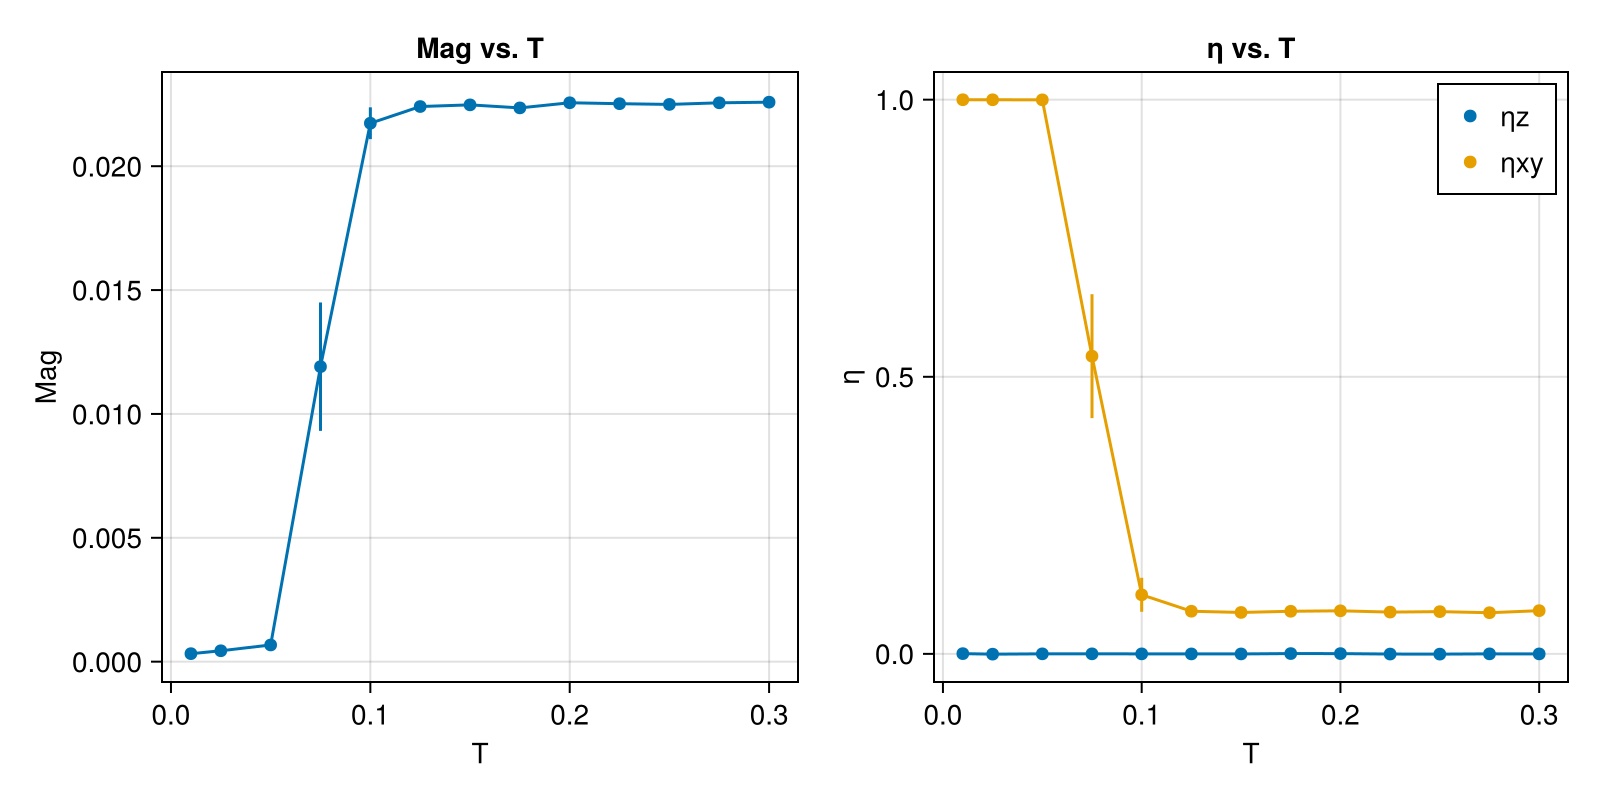

In [52]:
fig = Figure(size=(800, 400))
fig[1,1] = generatePlot(data, :T, :Mag; title="Mag vs. T", xlabel="T", ylabel="Mag", line=true)
fig[1,2] = generatePlot(data, :T, [:ηz, :ηxy]; title="η vs. T", xlabel="T", ylabel="η", line=true)
fig

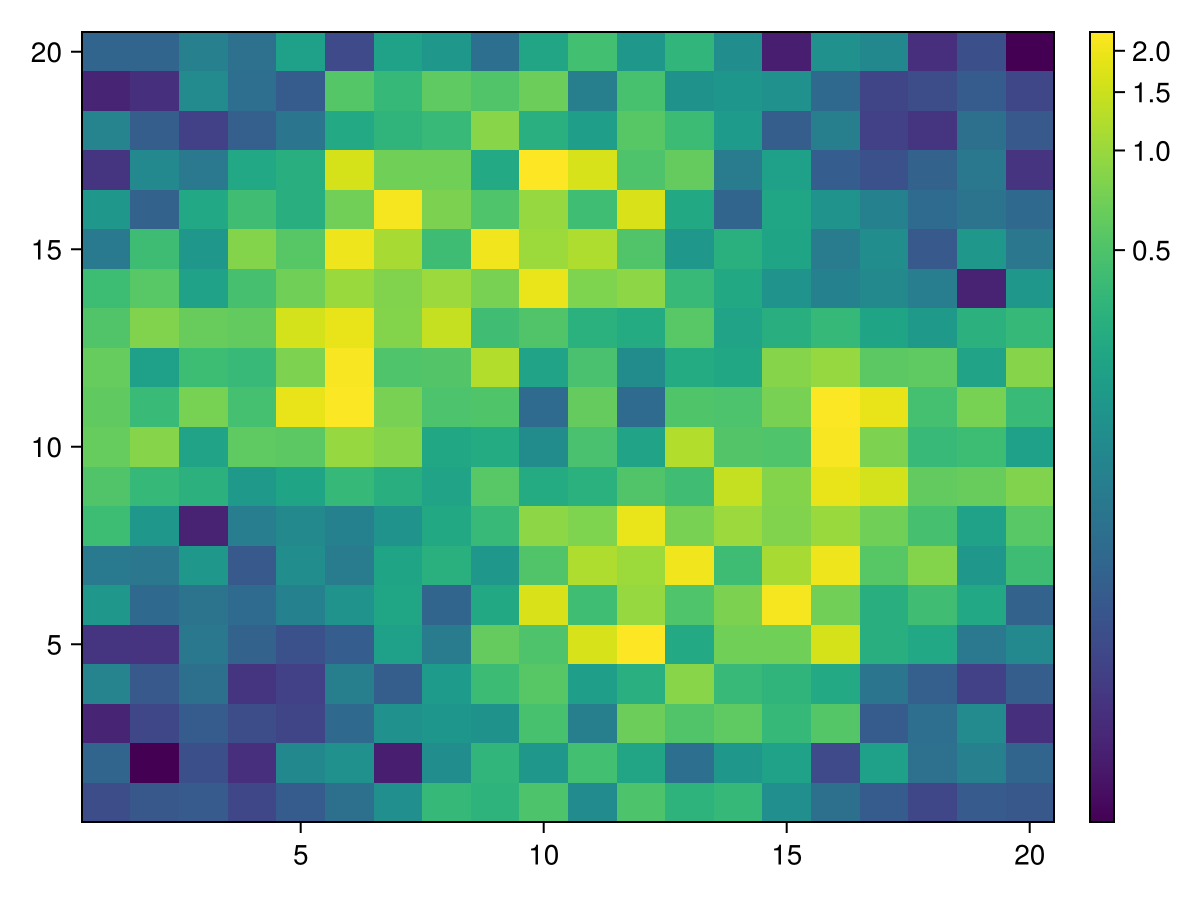

In [80]:
function get_spink_norms(data::AbstractDataFrame, i::Int)
    spin_ks = collect(eachslice(data[i, :spin_ks], dims=(1, 2)))
    spin_knorms = map(s -> sum(abs2.(s)), spin_ks)
    return getfield.(spin_knorms, :val)
end

fig = Figure(size=(500, 500))
ax = fig[1,1] = Axis(fig; title="Spin_k")
scale = ReversibleScale(log)
fig, ax, hm = heatmap(get_spink_norms(data, 6), colorscale=scale)
Colorbar(fig[1, 2], hm)
fig

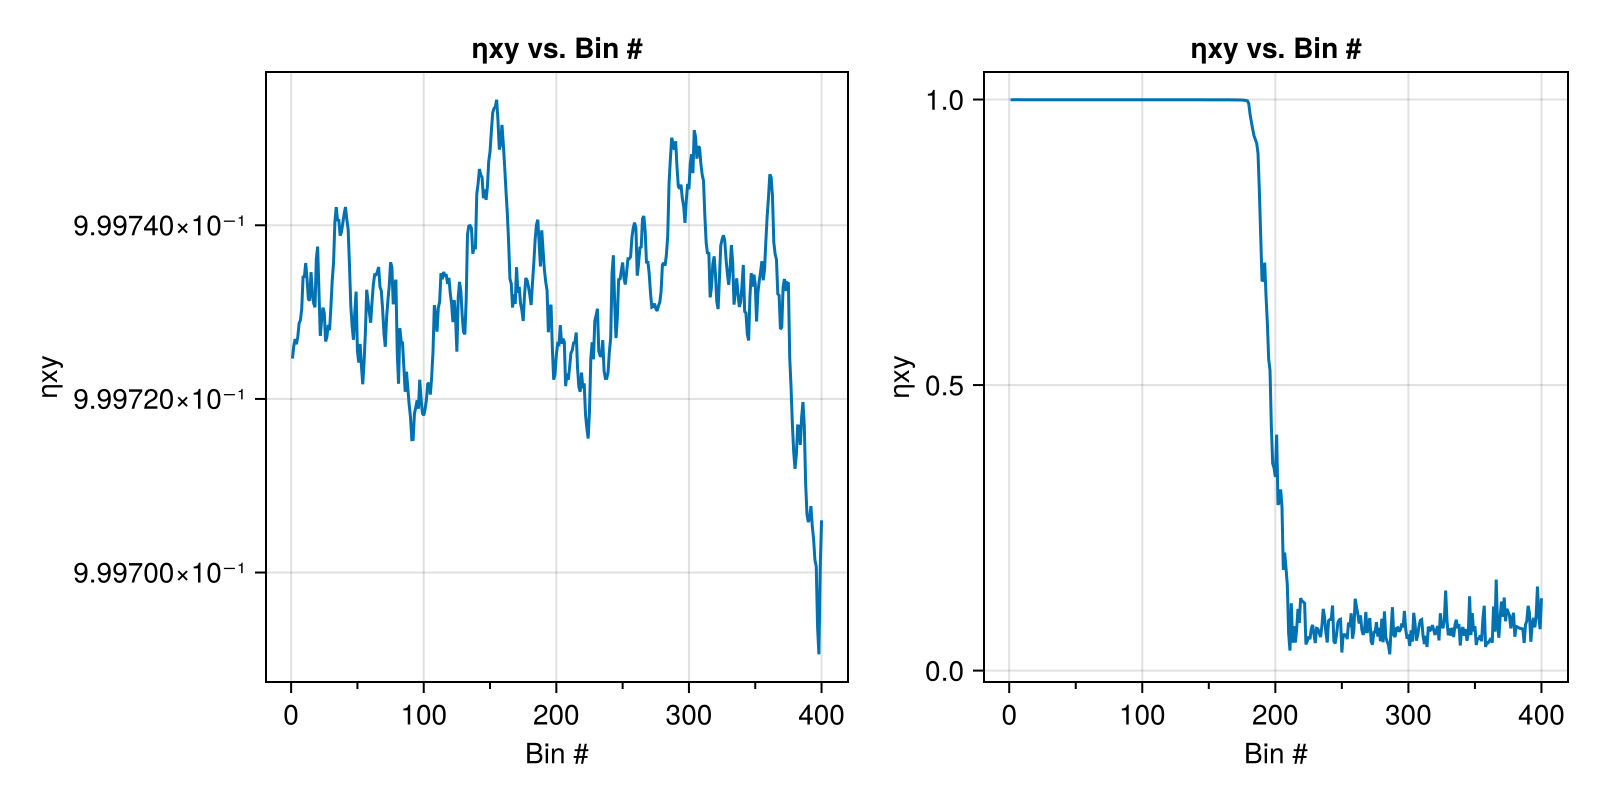

In [46]:
fig = Figure(size=(400, 800))
i = 3
fig = generate_mctime_plot(jobname, i, :ηxy)
generate_mctime_plot(jobname, i+1, :ηxy, fig, (1, 2))

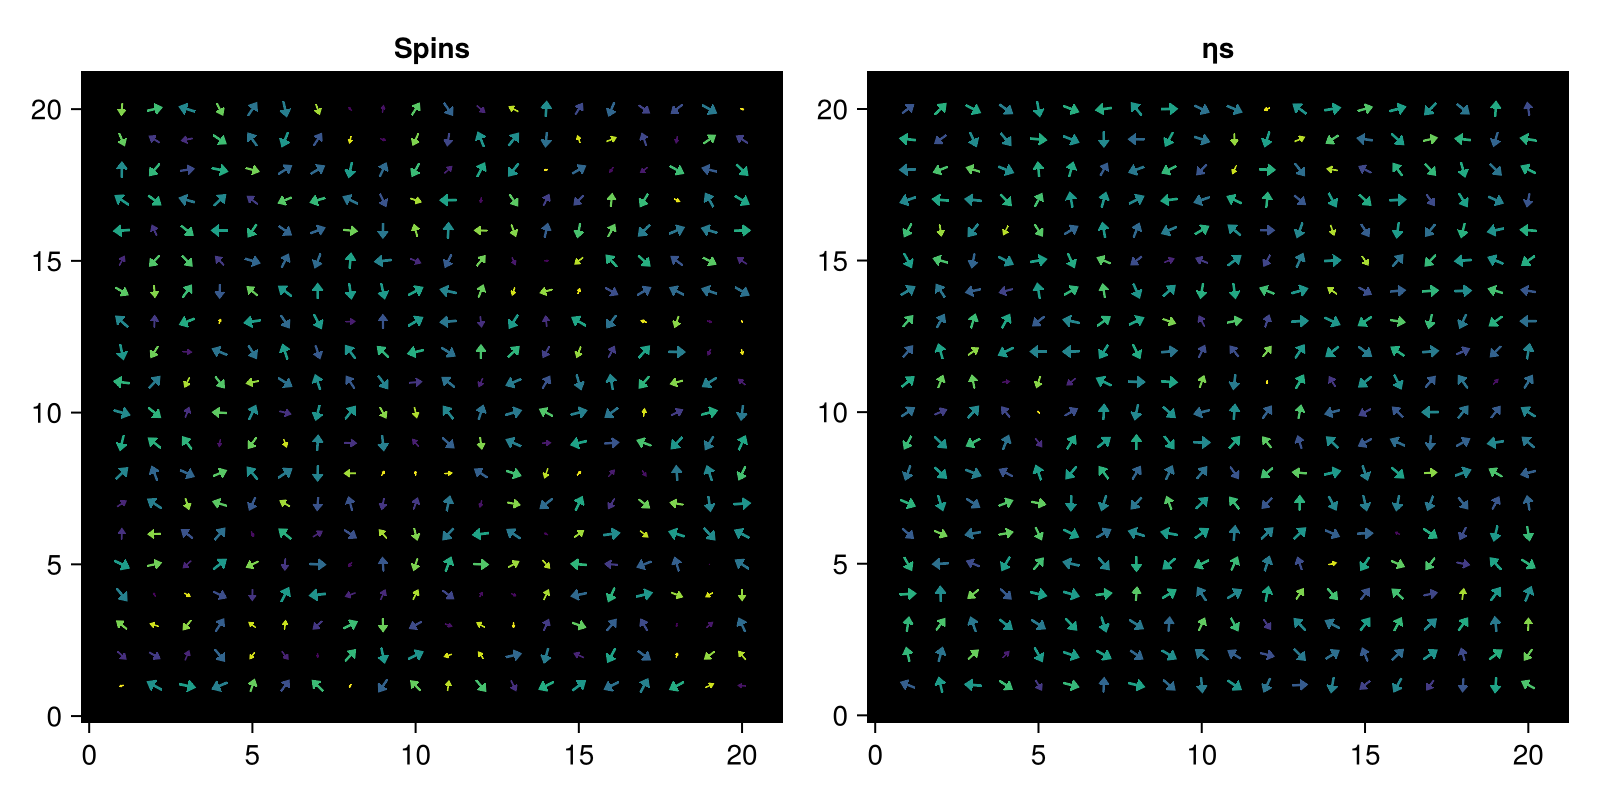

In [81]:
generate_spins(jobname, 5)